In [2]:
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets

from torch.utils.data import TensorDataset

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 

import numpy as np

import pickle

# Загрузка датасета

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
MNIST = datasets.FashionMNIST('./mnist', train=True, download=True, transform=None)
train_data_cnn = TensorDataset(MNIST.data.view(-1, 1, 28, 28).float() / 255, MNIST.targets)
train_data = TensorDataset(MNIST.data.view(-1, 28 * 28).float() / 255, MNIST.targets)

MNIST = datasets.FashionMNIST('./mnist', train=False, download=True, transform=None)
test_data_cnn = TensorDataset(MNIST.data.view(-1, 1, 28, 28).float() / 255, MNIST.targets)
test_data = TensorDataset(MNIST.data.view(-1, 28 * 28).float() / 255, MNIST.targets)

In [5]:
class Student(nn.Module):
    def __init__(self, input_dim = 784, output_dim = 10, device = 'cpu'):
        super(Student, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = nn.Linear(input_dim, output_dim)
        
        self.to(device)
        
    def forward(self, input):
        out = self.linear(input)
        return out

# Модель без учителя
В данной части получим качество логистической регресии на выборке FashionMNIST без использования дистиляции.

In [5]:
# list_of_student_models = []
# list_of_acc_train = []
# list_of_acc_test = []
# list_of_losses_train = []
# list_of_losses_test = []

# epochs = 100
# meaning = 20

# for tryes in tqdm(range(meaning)):

#     student = Student()

#     optimazir = optim.Adam(student.parameters())
#     loss_function = torch.nn.CrossEntropyLoss()

#     iterator = tqdm(range(epochs), leave=False)
#     iterator.set_postfix_str('epoch 0; loss: train nan test nan; acc: train nan test nan')

#     list_of_train_loss = []
#     list_of_test_loss = []
#     list_of_train_acc = []
#     list_of_test_acc = []
    
#     for i in iterator:
#         dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

#         epoch_loss = 0
#         epoch_true = 0
#         for x, y in dataloader:
#             optimazir.zero_grad()

#             predict = student(x)

#             loss = loss_function(predict, y)

#             loss.backward()

#             optimazir.step()

#             epoch_loss += loss.item()*len(y)
            
#             epoch_true += (torch.argmax(predict, axis=1) == y).sum().item()

#         testloader = DataLoader(test_data, batch_size=64, shuffle=False)
#         test_loss = 0
#         test_true = 0
#         for x, y in testloader:
#             predict = student(x)
#             loss = loss_function(predict, y)
#             test_loss += loss.item()*len(y)
            
#             test_true += (torch.argmax(predict, axis=1) == y).sum().item()

#         list_of_train_loss.append(epoch_loss/len(train_data))
#         list_of_test_loss.append(test_loss/len(test_data))
        
#         list_of_train_acc.append(epoch_true/len(train_data))
#         list_of_test_acc.append(test_true/len(test_data))

#         iterator.set_postfix_str(
#             'epoch {}; loss: train {} test {}; acc: train {} test {}'.format(
#                 i, 
#                 round(list_of_train_loss[-1], 2), 
#                 round(list_of_test_loss[-1], 2), 
#                 round(list_of_train_acc[-1], 2), 
#                 round(list_of_test_acc[-1], 2)))
        
#     list_of_losses_train.append(list_of_train_loss)
#     list_of_losses_test.append(list_of_test_loss)
    
#     list_of_acc_train.append(list_of_train_acc)
#     list_of_acc_test.append(list_of_test_acc)
    
#     list_of_student_models.append(student)

In [6]:
# with open('./dumps/list_of_student_models', 'wb') as f:
#     pickle.dump(list_of_student_models, f)
    
# with open('./dumps/list_of_losses_train', 'wb') as f:
#     pickle.dump(list_of_losses_train, f)
    
# with open('./dumps/list_of_losses_test', 'wb') as f:
#     pickle.dump(list_of_losses_test, f)
    
# with open('./dumps/list_of_acc_train', 'wb') as f:
#     pickle.dump(list_of_acc_train, f)
    
# with open('./dumps/list_of_acc_test', 'wb') as f:
#     pickle.dump(list_of_acc_test, f)

In [7]:
with open('./dumps/list_of_student_models', 'rb') as f:
    list_of_student_models = pickle.load(f)
    
with open('./dumps/list_of_losses_train', 'rb') as f:
    list_of_losses_train = pickle.load(f)
    
with open('./dumps/list_of_losses_test', 'rb') as f:
    list_of_losses_test = pickle.load(f)
    
with open('./dumps/list_of_acc_train', 'rb') as f:
    list_of_acc_train = pickle.load(f)
    
with open('./dumps/list_of_acc_test', 'rb') as f:
    list_of_acc_test = pickle.load(f)

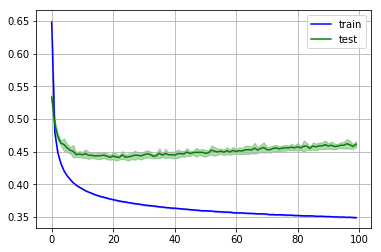

In [8]:
mean = np.array(list_of_losses_train).mean(0)
std = np.array(list_of_losses_train).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_losses_test).mean(0)
std = np.array(list_of_losses_test).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

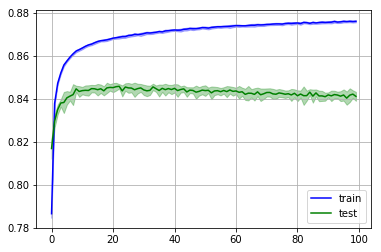

In [9]:
mean = np.array(list_of_acc_train).mean(0)
std = np.array(list_of_acc_train).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_acc_test).mean(0)
std = np.array(list_of_acc_test).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

# Модель с учителем
В данной части сначала обучем модель учителя --- двух слойную нейросеть. После чего дистилируем ее в логистическую регресию.

In [10]:
T = 2
lamb = 0.25

In [6]:
class Teacher(nn.Module):
    def __init__(self, device = 'cpu'):
        super(Teacher, self).__init__()
        
        output_dim = 10

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size = 5)
        self.conv2 = nn.Conv2d(3, 9, kernel_size = 5)
        self.linear1 = nn.Linear(9*4*4, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, output_dim)
        
        self.to(device)
        
    def forward(self, input):
        out = self.conv1(input)
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size = 2)
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size = 2)
        
        out = out.view(out.shape[0], -1)
        
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [7]:
teacher = Teacher()

In [15]:
suma = 0
for param in teacher.parameters():
    suma += numpy.prod(numpy.array(param.shape))

suma

29176

In [13]:
# optimazir = optim.Adam(teacher.parameters())
# loss_function = torch.nn.CrossEntropyLoss()

# epochs = 20
# iterator = tqdm(range(epochs))
# iterator.set_postfix_str('epoch 0; loss: train nan test nan; acc: train nan test nan')

# for i in iterator:
#     dataloader = DataLoader(train_data_cnn, batch_size=64, shuffle=True)
#     epoch_loss = 0
#     epoch_true = 0
#     teacher.train()
#     for x, y in dataloader:
#         optimazir.zero_grad()

#         predict = teacher(x)

#         loss = loss_function(predict, y)

#         loss.backward()

#         optimazir.step()

#         epoch_loss += loss.item()*len(y)

#         epoch_true += (torch.argmax(predict, axis=1) == y).sum().item()

#     testloader = DataLoader(test_data_cnn, batch_size=64, shuffle=False)
#     test_loss = 0
#     test_true = 0
#     teacher.eval()
#     for x, y in testloader:
#         predict = teacher(x)
#         loss = loss_function(predict, y)
        
#         test_loss += loss.item()*len(y)

#         test_true += (torch.argmax(predict, axis=1) == y).sum().item()
    
#     iterator.set_postfix_str(
#         'epoch {}; loss: train {} test {}; acc: train {} test {}'.format(
#             i, 
#             round(epoch_loss/len(train_data), 2),
#             round(test_loss/len(test_data), 2),
#             round(epoch_true/len(train_data), 2),
#             round(test_true/len(test_data), 2)))

In [14]:
# with open('./dumps/teacher', 'wb') as f:
#     pickle.dump(teacher, f)

In [15]:
with open('./dumps/teacher', 'rb') as f:
    teacher = pickle.load(f)

In [16]:
dataloader = DataLoader(train_data_cnn, batch_size=len(train_data_cnn), shuffle=False)
for x, y in dataloader:
    S = torch.softmax(teacher(x)/T, axis=1).detach()

In [17]:
for x, y in DataLoader(train_data, batch_size=len(train_data), shuffle=False):
    pass

In [18]:
all_train_data = TensorDataset(x, y, S)

In [19]:
# list_of_student_models_dist = []
# list_of_acc_train_dist = []
# list_of_acc_test_dist = []
# list_of_losses_train_dist = []
# list_of_losses_test_dist = []

# epochs = 100
# meaning = 5

# for tryes in tqdm(range(meaning)):

#     student = Student()

#     optimazir = optim.Adam(student.parameters())
#     loss_function = torch.nn.CrossEntropyLoss()

#     iterator = tqdm(range(epochs), leave=False)
#     iterator.set_postfix_str('epoch 0; loss: train nan test nan; acc: train nan test nan')

#     list_of_train_loss = []
#     list_of_test_loss = []
#     list_of_train_acc = []
#     list_of_test_acc = []
    
#     for i in iterator:
#         dataloader = DataLoader(all_train_data, batch_size=64, shuffle=True)

#         epoch_loss = 0
#         epoch_true = 0
#         for x, y, s in dataloader:
#             optimazir.zero_grad()

#             predict = student(x)
#             log_soft_pred = torch.log(torch.softmax(predict/T, axis=1))
            
#             loss = (1-lamb)*loss_function(predict, y) \
#                              - lamb*(s*log_soft_pred).mean() \
#                              - lamb*(log_soft_pred + torch.log(-log_soft_pred)).mean()

#             loss.backward()

#             optimazir.step()

#             epoch_loss += loss.item()*len(y)
            
#             epoch_true += (torch.argmax(predict, axis=1) == y).sum().item()

#         testloader = DataLoader(test_data, batch_size=64, shuffle=False)
#         test_loss = 0
#         test_true = 0
#         for x, y in testloader:
#             predict = student(x)
#             loss = loss_function(predict, y)
#             test_loss += loss.item()*len(y)
            
#             test_true += (torch.argmax(predict, axis=1) == y).sum().item()

#         list_of_train_loss.append(epoch_loss/len(train_data))
#         list_of_test_loss.append(test_loss/len(test_data))
        
#         list_of_train_acc.append(epoch_true/len(train_data))
#         list_of_test_acc.append(test_true/len(test_data))

#         iterator.set_postfix_str(
#             'epoch {}; loss: train {} test {}; acc: train {} test {}'.format(
#                 i, 
#                 round(list_of_train_loss[-1], 2), 
#                 round(list_of_test_loss[-1], 2), 
#                 round(list_of_train_acc[-1], 2), 
#                 round(list_of_test_acc[-1], 2)))
        
#     list_of_losses_train_dist.append(list_of_train_loss)
#     list_of_losses_test_dist.append(list_of_test_loss)
    
#     list_of_acc_train_dist.append(list_of_train_acc)
#     list_of_acc_test_dist.append(list_of_test_acc)
    
#     list_of_student_models_dist.append(student)

In [20]:
# with open('./dumps/list_of_student_models_dist', 'wb') as f:
#     pickle.dump(list_of_student_models_dist, f)
    
# with open('./dumps/list_of_losses_train_dist', 'wb') as f:
#     pickle.dump(list_of_losses_train_dist, f)
    
# with open('./dumps/list_of_losses_test_dist', 'wb') as f:
#     pickle.dump(list_of_losses_test_dist, f)
    
# with open('./dumps/list_of_acc_train_dist', 'wb') as f:
#     pickle.dump(list_of_acc_train_dist, f)
    
# with open('./dumps/list_of_acc_test_dist', 'wb') as f:
#     pickle.dump(list_of_acc_test_dist, f)

In [21]:
with open('./dumps/list_of_student_models_dist', 'rb') as f:
    list_of_student_models_dist = pickle.load(f)
    
with open('./dumps/list_of_losses_train_dist', 'rb') as f:
    list_of_losses_train_dist = pickle.load(f)
    
with open('./dumps/list_of_losses_test_dist', 'rb') as f:
    list_of_losses_test_dist = pickle.load(f)
    
with open('./dumps/list_of_acc_train_dist', 'rb') as f:
    list_of_acc_train_dist = pickle.load(f)
    
with open('./dumps/list_of_acc_test_dist', 'rb') as f:
    list_of_acc_test_dist = pickle.load(f)

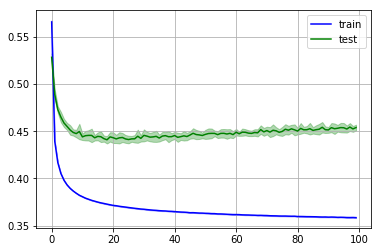

In [22]:
mean = np.array(list_of_losses_train_dist).mean(0)
std = np.array(list_of_losses_train_dist).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_losses_test_dist).mean(0)
std = np.array(list_of_losses_test_dist).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

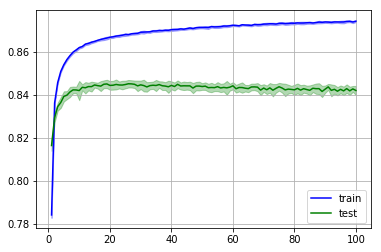

In [23]:
mean = np.array(list_of_acc_train_dist).mean(0)
std = np.array(list_of_acc_train_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_acc_test_dist).mean(0)
std = np.array(list_of_acc_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

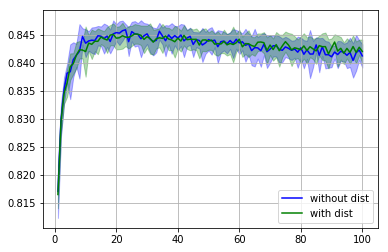

In [24]:
mean = np.array(list_of_acc_test).mean(0)
std = np.array(list_of_acc_test).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'without dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')



mean = np.array(list_of_acc_test_dist).mean(0)
std = np.array(list_of_acc_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'with dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

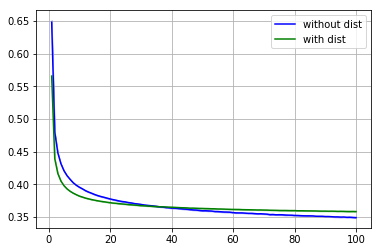

In [25]:
mean = np.array(list_of_losses_train).mean(0)
std = np.array(list_of_losses_train).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'without dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')



mean = np.array(list_of_losses_train_dist).mean(0)
std = np.array(list_of_losses_train_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'with dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

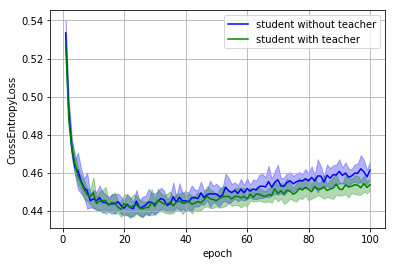

In [26]:
mean = np.array(list_of_losses_test).mean(0)
std = np.array(list_of_losses_test).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'student without teacher')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')



mean = np.array(list_of_losses_test_dist).mean(0)
std = np.array(list_of_losses_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'student with teacher')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')

plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')

plt.grid()
plt.legend(loc='best')
plt.show()

In [32]:
np.array(list_of_losses_test_dist).mean(0)[-1]


0.8420600000000003

In [33]:
np.array(list_of_losses_test_dist).std(0)[-1]


0.002136913662270897

In [34]:
np.array(list_of_losses_test).mean(0)[-1]


0.8412649999999999

In [35]:
np.array(list_of_losses_test).std(0)[-1]


0.0020933884016111327